# AUEB M.Sc. in Data Science (part-time)

### 2024.04 - 2024.06

Exercise 3

**Course**: Text Analytics   
**Authors**:
Anagnos Theodoros (p3352323) -
Michalopoulos Ioannis (p3352314) -
Kafantaris Panagiotis (p3352328) -  
Vigkos Ioannis (p3352326)

**Date**: 2024-04-29

installing libraries

In [1]:
!pip install --upgrade tensorflow

     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ----------------------------------- ---- 41.0/46.2 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 765.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 4.3 MB/s eta 0:01:28
   ---------------------------------------- 0.2/377.0 MB 3.1 MB/s eta 0:02:01
   ---------------------------------------- 0.6/377.0 MB 6.6 MB/s eta 0:00:57
   ---------------------------------------- 0.9/377.0 MB 6.4 MB/s eta 0:00:59
   ---------------------------------------- 1.0/377.0 MB 6.8 MB/s eta 0:00:56
   ---------------------------------------- 1.1/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 1.7/377.0 MB 6.6 MB/s eta 0:00:57
   ---------------------------------------- 1.9/377.0 MB 6.8 MB/s eta 0:00:56
   ---------------------------------------- 2.0/377.0 MB 6.7 MB/s eta 0:0

In [2]:
!pip install conllu

download dataset

In [7]:
# !wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu -O en_ewt_dev.conllu
import requests
# Download the data using requests
url = 'https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu'
response = requests.get(url)
with open('en_ewt_dev.conllu', 'wb') as f:
    f.write(response.content)

we tokenize the sentences and build the lists accordingly. We seperate words from tags into different variables for every subset

In [8]:
from conllu import parse
from sklearn.model_selection import train_test_split

def parse_conllu(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
        sentences = parse(data)
    return sentences

def extract_words_and_tags(sentences):
    words = []
    tags = []
    for sentence in sentences: # we loop in each sentene
        for token in sentence: # we loop in each token/word
            if token['form'] and token['upostag']:
                words.append(token['form']) # we take the word
                tags.append(token['upostag']) # we take the tag
    return words, tags

sentences = parse_conllu("en_ewt_dev.conllu")
words, tags = extract_words_and_tags(sentences)

# Split the data
train_words, temp_words, train_tags, temp_tags = train_test_split(words, tags, test_size=0.4, random_state=42)
dev_words, test_words, dev_tags, test_tags = train_test_split(temp_words, temp_tags, test_size=0.5, random_state=42)

In [9]:
len(train_words), len(dev_words), len(test_words)

(15307, 5102, 5103)

we make sure everything is in lower case

In [10]:
train_words = [word.lower() for word in train_words]
dev_words = [word.lower() for word in dev_words]
test_words = [word.lower() for word in test_words]

example

In [11]:
print(train_words[:10])
print(train_tags[:10])

['make', 'when', 'by', 'which', 'from', 'palestinian', 'landed', 'the', 'and', 'reports']
['VERB', 'ADV', 'ADP', 'DET', 'ADP', 'ADJ', 'VERB', 'DET', 'CCONJ', 'VERB']


## Sliding Window implementation

In [12]:
# Convert to windowed dataset
def convert_to_window_dataset(words, tags, window_size, pad_symbol='</s>'):
    half_window = window_size // 2
    padded_words = [pad_symbol] * half_window + words + [pad_symbol] * half_window
    windowed_sentences = []
    windowed_tags = []
    for i in range(len(words)):
        windowed_sentences.append(padded_words[i:i + window_size])
        windowed_tags.append(tags[i])
    return windowed_sentences, windowed_tags

train_words, train_tags = convert_to_window_dataset(train_words, train_tags, 3)
dev_words, dev_tags = convert_to_window_dataset(dev_words, dev_tags, 3)
test_words, test_tags = convert_to_window_dataset(test_words, test_tags, 3)

In [13]:
### Build the vocabulary
flat_train_words = [word for sublist in train_words for word in sublist]
vocab = {word: idx for idx, word in enumerate(set(flat_train_words))}
vocab_tags = {tag: idx for idx, tag in enumerate(set(train_tags))}

In [14]:
len(vocab), len(vocab_tags)

(3627, 18)

Get the W2V embendings

In [16]:
!pip install -U keras-tuner requests gensim

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------------------- -------------------- 61.4/129.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/63.9 kB ? eta -:--:--
   ---------------------------------------- 63.9/63.9 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/24.0 MB 7.3 MB/s eta 0:00:04
    --------------------------------------- 0.5/24.0 MB 6.3 MB/s eta 0:00:04
   - -------------------------------------- 0.7/24.0 MB 6.7 MB/s eta 0:00:04
   - -------------------------------------- 0.7/24.0 MB 6.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.2/24.0 MB 6.6 MB/s eta 0:00:04
   -- ------------------------------------- 1.5/24.0 MB 7.0 MB/s eta 0:00:04
   -- ------------------------------------- 1.7/24.0 MB 6.9 MB/s eta 0:00:04
   -- -------

In [17]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1661.6/1662.8MB downloaded


Map each word with its embending matrix. We do the same for every subset. We initialize with zeros, each words that isnt included in the vocabulary (wv)

In [18]:
import numpy as np

# Function to map words to embeddings
def map_vocab_to_embeddings(vocab, wv, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in wv:
            embedding_matrix[idx] = wv[word]
        else:
            # Handle out-of-vocabulary (OOV) words by initializing with zeros
            embedding_matrix[idx] = np.zeros(embedding_dim)
    return embedding_matrix

# Map vocab to embeddings
embeddings = map_vocab_to_embeddings(vocab, wv)


In [19]:
embeddings.shape

(3627, 300)

we build the one-hot encoding for each subset in order to use it as a feature in our model later.

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Encode POS tags
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)

train_tags_encoded = onehot_encoder.fit_transform(label_encoder.fit_transform(train_tags).reshape(-1, 1))
dev_tags_encoded = onehot_encoder.transform(label_encoder.transform(dev_tags).reshape(-1, 1))
test_tags_encoded = onehot_encoder.transform(label_encoder.transform(test_tags).reshape(-1, 1))


In [21]:
# Convert words to indices
def words_to_indices(words, vocab):
    return np.array([[vocab.get(word, 0) for word in window] for window in words])

train_words_idx = words_to_indices(train_words, vocab)
dev_words_idx = words_to_indices(dev_words, vocab)
test_words_idx = words_to_indices(test_words, vocab)

We define our MLP model. We start from a random architecture and later we do Hyperparameter tuning. We set EarlyStopping to patience=3. Which means that after 3 epochs that validation loss will be worse the process will stop and will save the best weights (restore_best_weights=True)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqWeightedAttention


GRU_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model1 = Sequential()
  # add an embedding layer
  model1.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model1.add(Dropout(0.20))
  # add a bidirectional gru layer with 0.33 variational (recurrent) dropout 
  model1.add(Bidirectional(GRU(GRU_SIZE, recurrent_dropout = 0.20)))
  # dropout layer
  model1.add(Dropout(0.20))
  # add a hidden MLP layer
  model1.add(Dense(DENSE, activation='relu' ))
  # dropout layer
  model1.add(Dropout(0.20))
  # add the output MLP layer
  model1.add(Dense(1,  activation = 'sigmoid'))

  model1.compile(
   # Loss function to minimize
     loss = 'binary_crossentropy',
     optimizer = Adam(learning_rate = 0.001),
   # List of metrics to monitor
     metrics = [precision, recall, f1, accuracy]
  )

  RNN_model = model1.fit(
      train_data, 
      y_train.to_numpy(),
      batch_size = 1000,
      epochs = 50,
      verbose = 0,
      callbacks = [es], shuffle = True, validation_data=(dev_data, y_dev.to_numpy()))

  plot_history(RNN_model)

In [23]:
import tensorflow as tf

# Metrics callback
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = np.argmax(self.validation_data[1], -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return


In [28]:
# Ensure TensorFlow is using GPU 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is set")
    except RuntimeError as e:
        print(e)


In [34]:
!pip install tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\tanagnos\an

In [33]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [32]:
# Define the model and train it using GPU 0
with tf.device('/device:GPU:1'):
    model = Sequential([
        Input(shape=(3,), dtype='int32', name='Input_Layer'),
        Embedding(len(vocab), 300, weights=[embeddings], input_length=3, trainable=True),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(vocab_tags), activation='softmax')  # Output layer multi-class classification
    ])

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[CategoricalAccuracy()])

    early_stopping = EarlyStopping(patience=10, verbose=2, restore_best_weights=True, monitor='val_loss', mode='min')

    history = model.fit(
        train_words_idx, train_tags_encoded,
        validation_data=(dev_words_idx, dev_tags_encoded),
        batch_size=256, epochs=100, shuffle=True,
        callbacks=[early_stopping])
  

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 3, 300)              │       1,088,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,353,974 (5.17 MB)

 Trainable params: 1,353,974 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.2106 - loss: 2.5328 - val_categorical_accuracy: 0.6441 - val_loss: 1.2923
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.7108 - loss: 1.0541 - val_categorical_accuracy: 0.7468 - val_loss: 0.9864
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8542 - loss: 0.5417 - val_categorical_accuracy: 0.7691 - val_loss: 1.0779
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8956 - loss: 0.3655 - val_categorical_accuracy: 0.7719 - val_loss: 1.2239
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.9217 - loss: 0.2784 - val_categorical_accuracy: 0.7724 - val_loss: 1.1874
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.9369 - loss: 0.2181 - val_categorical_accuracy: 0.7685 - val_loss: 1.2811
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.9480 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, recall_score, precision_score

with tf.device('/device:GPU:0'):
    model = Sequential([
        Input(shape=(3,),dtype='int32',name='Input_Layer'),
        Embedding(len(vocab), 300, weights=[embeddings], input_length=3, trainable=True),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(vocab_tags), activation='softmax')  # Output layer multi-class classification
    ])

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[CategoricalAccuracy()])

    early_stopping = EarlyStopping(patience=10, verbose=2, restore_best_weights=True, monitor='val_loss', mode='min')

    history = model.fit(
        train_words_idx, train_tags_encoded,
        validation_data=(dev_words_idx, dev_tags_encoded),
        batch_size=256, epochs=100, shuffle=True,
        callbacks=[Metrics(valid_data=(dev_words_idx, dev_tags_encoded)), early_stopping]
    )

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 3, 300)              │       1,088,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,353,974 (5.17 MB)

 Trainable params: 1,353,974 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.2259 - 
 — val_f1: 0.6125859518955719 — val_precision: 0.604245362196918 — val_recall: 0.6493531948255586
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - categorical_accuracy: 0.2330 - loss: 2.5086 - val_categorical_accuracy: 0.6494 - val_loss: 1.2945 - val_f1: 0.6126 - val_recall: 0.6494 - val_precision: 0.6042
Epoch 2/100
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.6656 - loss: 1.2132

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.7099 - los
 — val_f1: 0.7704374117015278 — val_precision: 0.8360785724695351 — val_recall: 0.7559780478243826
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.7120 - loss: 1.0359 - val_categorical_accuracy: 0.7560 - val_loss: 1.0309 - val_f1: 0.7704 - val_recall: 0.7560 - val_precision: 0.8361
Epoch 3/100
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8597 - loss: 0.5058

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.8580 - l
 — val_f1: 0.7807450564722639 — val_precision: 0.8447677374701827 — val_recall: 0.7610740885927088
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.8581 - loss: 0.5065 - val_categorical_accuracy: 0.7611 - val_loss: 1.1192 - val_f1: 0.7807 - val_recall: 0.7611 - val_precision: 0.8448
Epoch 4/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8978 - loss: 0.3409

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.8954 - l
 — val_f1: 0.789608738297511 — val_precision: 0.853941253808855 — val_recall: 0.7685221481771854
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.8954 - loss: 0.3595 - val_categorical_accuracy: 0.7685 - val_loss: 1.2501 - val_f1: 0.7896 - val_recall: 0.7685 - val_precision: 0.8539
Epoch 5/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9278 - loss: 0.2600

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9225 - l
 — val_f1: 0.7911028919363678 — val_precision: 0.8502850600013457 — val_recall: 0.7718541748333987
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.9224 - loss: 0.2711 - val_categorical_accuracy: 0.7719 - val_loss: 1.3005 - val_f1: 0.7911 - val_recall: 0.7719 - val_precision: 0.8503
Epoch 6/100
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9286 - loss: 0.2374

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9357 - los
 — val_f1: 0.7961599165495211 — val_precision: 0.8647990510605116 — val_recall: 0.7728341826734614
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.9356 - loss: 0.2171 - val_categorical_accuracy: 0.7728 - val_loss: 1.4452 - val_f1: 0.7962 - val_recall: 0.7728 - val_precision: 0.8648
Epoch 7/100
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9507 - loss: 0.1777

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9492 - l
 — val_f1: 0.7959702775722318 — val_precision: 0.860085690856246 — val_recall: 0.7726381811054488
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.9492 - loss: 0.1750 - val_categorical_accuracy: 0.7726 - val_loss: 1.4642 - val_f1: 0.7960 - val_recall: 0.7726 - val_precision: 0.8601
Epoch 8/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9533 - loss: 0.1465

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9548 - l
 — val_f1: 0.7945133534206636 — val_precision: 0.8588605409914991 — val_recall: 0.7710701685613485
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.9548 - loss: 0.1522 - val_categorical_accuracy: 0.7711 - val_loss: 1.5789 - val_f1: 0.7945 - val_recall: 0.7711 - val_precision: 0.8589
Epoch 9/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9680 - loss: 0.1141

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9645 - l
 — val_f1: 0.7933862732084608 — val_precision: 0.8561502754146778 — val_recall: 0.7704821638573108
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.9644 - loss: 0.1201 - val_categorical_accuracy: 0.7705 - val_loss: 1.5508 - val_f1: 0.7934 - val_recall: 0.7705 - val_precision: 0.8562
Epoch 10/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9675 - loss: 0.1044

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9683 - l
 — val_f1: 0.7914996032140272 — val_precision: 0.8540550887406935 — val_recall: 0.7677381419051352
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.9683 - loss: 0.1056 - val_categorical_accuracy: 0.7677 - val_loss: 1.6633 - val_f1: 0.7915 - val_recall: 0.7677 - val_precision: 0.8541
Epoch 11/100
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9669 - loss: 0.0918

C:\Users\tanagnos\anaconda3\envs\PDS\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9704 - l
 — val_f1: 0.7940967527466007 — val_precision: 0.8563712901150329 — val_recall: 0.7722461779694237
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.9705 - loss: 0.0907 - val_categorical_accuracy: 0.7722 - val_loss: 1.7428 - val_f1: 0.7941 - val_recall: 0.7722 - val_precision: 0.8564
Epoch 12/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  categorical_accuracy: 0.9815 -
 — val_f1: 0.7910532161518945 — val_precision: 0.8533357388057137 — val_recall: 0.7691101528812231
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - categorical_accuracy: 0.9813 - loss: 0.0656 - val_categorical_accuracy: 0.7691 - val_loss: 1.6947 - val_f1: 0.7911 - val_recall: 0.7691 - val_precision: 0.8533
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.


## Hyper-parameter tuning

In [26]:
# def build_tunable_model(hp):
#     model = Sequential()
#     model.add(Embedding(len(vocab), 300, weights=[embeddings], input_length=3, trainable=True))
#     model.add(Flatten())
#     for i in range(hp.Int('num_layers', 1, 5)):
#         model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
#                         activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh'])))
#         model.add(BatchNormalization())
#         model.add(Dropout(rate=hp.Choice('dropout_' + str(i), values=[0.1, 0.5])))

#     model.add(Dense(len(vocab_tags), activation='softmax'))
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
#                   loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])
#     return model

from tensorflow.keras.regularizers import l2

def build_tunable_model(hp):
    model = Sequential()
    model.add(Embedding(len(vocab), 300, weights=[embeddings], input_length=3, trainable=True))
    model.add(Flatten())
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh']),
                        kernel_regularizer=l2(0.01)))  # Added L2 regularization
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_' + str(i), values=[0.3, 0.5, 0.7])))  # Increased dropout rates

    model.add(Dense(len(vocab_tags), activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])
    return model

# Instantiate the tuner
tuner = RandomSearch(build_tunable_model, objective=Objective("val_categorical_accuracy", direction="max"),
                     max_trials=10, executions_per_trial=1, directory='KT_dir', project_name='KT_tuning')

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=2)

# Search for the best hyperparameters
tuner.search(train_words_idx, train_tags_encoded, epochs=80, validation_data=(dev_words_idx, dev_tags_encoded),
             callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(test_words_idx, test_tags_encoded)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# best_model.save("MLP_centroids.keras")

NameError: name 'RandomSearch' is not defined

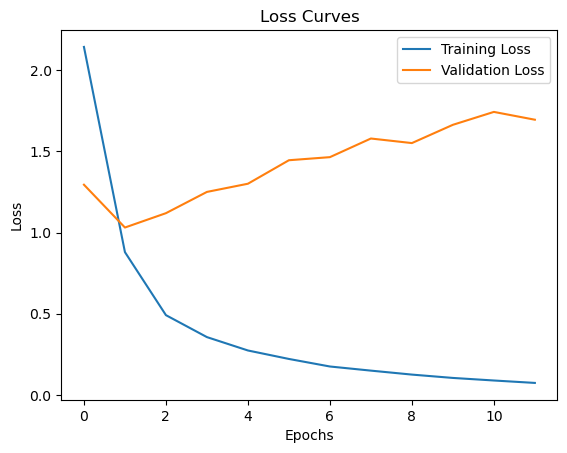

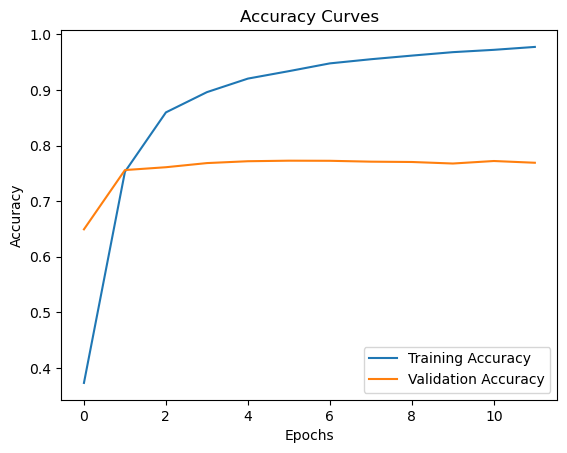

In [27]:
# Plot loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Save accuracy plots
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('accuracy_plot.png')
plt.show()

In [20]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters.values}")

Best hyperparameters: {'num_layers': 4, 'units_0': 256, 'activation_0': 'relu', 'dropout_0': 0.5, 'learning_rate': 0.001, 'units_1': 448, 'activation_1': 'relu', 'dropout_1': 0.5, 'units_2': 448, 'activation_2': 'relu', 'dropout_2': 0.5, 'units_3': 192, 'activation_3': 'tanh', 'dropout_3': 0.1, 'units_4': 448, 'activation_4': 'relu', 'dropout_4': 0.1}


In [25]:
# Baseline: Most frequent tag
most_frequent_tag = max(set(train_tags), key=train_tags.count)
baseline_predictions = [most_frequent_tag] * len(test_tags)

# Calculate precision, recall, F1 score, and precision-recall AUC
def evaluate_model(predictions, true_tags):
    precision = precision_score(true_tags, predictions, average=None, labels=label_encoder.classes_)
    recall = recall_score(true_tags, predictions, average=None, labels=label_encoder.classes_)
    f1 = f1_score(true_tags, predictions, average=None, labels=label_encoder.classes_)
    pr_auc = []
    for i, class_name in enumerate(label_encoder.classes_):
        precision_, recall_, _ = precision_recall_curve((true_tags == i).astype(int), (predictions == i).astype(int))
        pr_auc.append(auc(recall_, precision_))
    return precision, recall, f1, pr_auc

# Helper function to print scores
def print_scores(precision, recall, f1, pr_auc, label_encoder):
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"Class: {class_name}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
        print(f"  PR AUC: {pr_auc[i]:.4f}")

# Helper function to calculate macro-averaged scores
def macro_average(precision, recall, f1, pr_auc):
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    macro_pr_auc = np.mean(pr_auc)
    return macro_precision, macro_recall, macro_f1, macro_pr_auc

# Evaluate on test set
test_predictions = np.argmax(best_model.predict(test_words_idx), axis=-1)
test_true = np.argmax(test_tags_encoded, axis=-1)

precision, recall, f1, pr_auc = evaluate_model(test_predictions, test_true)
print("Test Set Scores:")
print_scores(precision, recall, f1, pr_auc, label_encoder)

macro_precision, macro_recall, macro_f1, macro_pr_auc = macro_average(precision, recall, f1, pr_auc)
print(f"Macro-Averaged Precision: {macro_precision:.4f}")
print(f"Macro-Averaged Recall: {macro_recall:.4f}")
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")
print(f"Macro-Averaged PR AUC: {macro_pr_auc:.4f}")

# Evaluate on development set
dev_predictions = np.argmax(best_model.predict(dev_words_idx), axis=-1)
dev_true = np.argmax(dev_tags_encoded, axis=-1)

precision, recall, f1, pr_auc = evaluate_model(dev_predictions, dev_true)
print("Development Set Scores:")
print_scores(precision, recall, f1, pr_auc, label_encoder)

macro_precision, macro_recall, macro_f1, macro_pr_auc = macro_average(precision, recall, f1, pr_auc)
print(f"Macro-Averaged Precision: {macro_precision:.4f}")
print(f"Macro-Averaged Recall: {macro_recall:.4f}")
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")
print(f"Macro-Averaged PR AUC: {macro_pr_auc:.4f}")

# Evaluate on training set
train_predictions = np.argmax(best_model.predict(train_words_idx), axis=-1)
train_true = np.argmax(train_tags_encoded, axis=-1)

precision, recall, f1, pr_auc = evaluate_model(train_predictions, train_true)
print("Training Set Scores:")
print_scores(precision, recall, f1, pr_auc, label_encoder)

macro_precision, macro_recall, macro_f1, macro_pr_auc = macro_average(precision, recall, f1, pr_auc)
print(f"Macro-Averaged Precision: {macro_precision:.4f}")
print(f"Macro-Averaged Recall: {macro_recall:.4f}")
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")
print(f"Macro-Averaged PR AUC: {macro_pr_auc:.4f}")

# Evaluate baseline
baseline_precision, baseline_recall, baseline_f1, baseline_pr_auc = evaluate_model(baseline_predictions, test_true)
print("Baseline Scores:")
print_scores(baseline_precision, baseline_recall, baseline_f1, baseline_pr_auc, label_encoder)

baseline_macro_precision, baseline_macro_recall, baseline_macro_f1, baseline_macro_pr_auc = macro_average(baseline_precision, baseline_recall, baseline_f1, baseline_pr_auc)
print(f"Baseline Macro-Averaged Precision: {baseline_macro_precision:.4f}")
print(f"Baseline Macro-Averaged Recall: {baseline_macro_recall:.4f}")
print(f"Baseline Macro-Averaged F1 Score: {baseline_macro_f1:.4f}")
print(f"Baseline Macro-Averaged PR AUC: {baseline_macro_pr_auc:.4f}")

160/160 [==============================] - 1s 3ms/step
Test Set Scores:
Class: ADJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7681
Class: ADP
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8738
Class: ADV
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7625
Class: AUX
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8729
Class: CCONJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9758
Class: DET
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9588
Class: INTJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7605
Class: NOUN
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7969
Class: NUM
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.6959
Class: PART
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7751
Class: PRON
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.948

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


160/160 [==============================] - 1s 3ms/step
Development Set Scores:
Class: ADJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7906
Class: ADP
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8642
Class: ADV
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7832
Class: AUX
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8872
Class: CCONJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9819
Class: DET
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9659
Class: INTJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7235
Class: NOUN
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7884
Class: NUM
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.7127
Class: PART
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8064
Class: PRON
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


479/479 [==============================] - 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Training Set Scores:
Class: ADJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9812
Class: ADP
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9395
Class: ADV
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9401
Class: AUX
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9603
Class: CCONJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9979
Class: DET
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9787
Class: INTJ
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.8753
Class: NOUN
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9840
Class: NUM
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9625
Class: PART
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9404
Class: PRON
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  PR AUC: 0.9816
Class: PROPN
  Precision: 0.0000
  Recall: 0.0000

ValueError: Mix of label input types (string and number)

one-hot encoding for test data

In [ ]:
# Encode POS tags for test data
test_tags_encoded = label_encoder.transform(test_tags)
test_tags_encoded = onehot_encoder.transform(test_tags_encoded.reshape(-1, 1))

evaluate the model

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_embeddings, test_tags_encoded)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [26]:
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, recall_score, precision_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X, y_true, label_encoder):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)
    y_true = np.argmax(y_true, axis=-1)

    # Decode the labels back to original tags
    y_true_tags = label_encoder.inverse_transform(y_true)
    y_pred_tags = label_encoder.inverse_transform(y_pred)

    # Print classification report
    report = classification_report(y_true_tags, y_pred_tags, output_dict=True)
    print("Classification Report:\n", classification_report(y_true_tags, y_pred_tags))

    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))

    # Calculate precision-recall AUC for each class
    precision = {}
    recall = {}
    pr_auc = {}
    for i, label in enumerate(label_encoder.classes_):
        precision[label], recall[label], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        pr_auc[label] = auc(recall[label], precision[label])

    # Calculate macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    macro_pr_auc = np.mean(list(pr_auc.values()))

    # Calculate micro-averaged scores
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Micro-averaged precision-recall AUC
    precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    micro_pr_auc = auc(recall_micro, precision_micro)

    print(f"Micro-averaged Precision: {micro_precision}")
    print(f"Micro-averaged Recall: {micro_recall}")
    print(f"Micro-averaged F1-Score: {micro_f1}")
    print(f"Micro-averaged Precision-Recall AUC: {micro_pr_auc}")

    return report, macro_precision, macro_recall, macro_f1, macro_pr_auc, precision, recall, pr_auc, micro_precision, micro_recall, micro_f1, micro_pr_auc

In [27]:
# Evaluate on training set
print("Training Set Metrics:")
report_train, macro_precision_train, macro_recall_train, macro_f1_train, macro_pr_auc_train, precision_train, recall_train, pr_auc_train, micro_precision_train, micro_recall_train, micro_f1_train, micro_pr_auc_train = evaluate_model(model, train_embeddings, train_tags_encoded, label_encoder)
print(f"Training Set - Macro Precision: {macro_precision_train}, Macro Recall: {macro_recall_train}, Macro F1: {macro_f1_train}, Macro PR AUC: {macro_pr_auc_train}")
print(f"Training Set - Micro Precision: {micro_precision_train}, Micro Recall: {micro_recall_train}, Micro F1: {micro_f1_train}, Micro PR AUC: {micro_pr_auc_train}")

# Evaluate on development set
print("Development Set Metrics:")
report_dev, macro_precision_dev, macro_recall_dev, macro_f1_dev, macro_pr_auc_dev, precision_dev, recall_dev, pr_auc_dev, micro_precision_dev, micro_recall_dev, micro_f1_dev, micro_pr_auc_dev = evaluate_model(model, dev_embeddings, dev_tags_encoded, label_encoder)
print(f"Development Set - Macro Precision: {macro_precision_dev}, Macro Recall: {macro_recall_dev}, Macro F1: {macro_f1_dev}, Macro PR AUC: {macro_pr_auc_dev}")
print(f"Development Set - Micro Precision: {micro_precision_dev}, Micro Recall: {micro_recall_dev}, Micro F1: {micro_f1_dev}, Micro PR AUC: {micro_pr_auc_dev}")

# Evaluate on test set
print("Test Set Metrics:")
report_test, macro_precision_test, macro_recall_test, macro_f1_test, macro_pr_auc_test, precision_test, recall_test, pr_auc_test, micro_precision_test, micro_recall_test, micro_f1_test, micro_pr_auc_test = evaluate_model(model, test_embeddings, test_tags_encoded, label_encoder)
print(f"Test Set - Macro Precision: {macro_precision_test}, Macro Recall: {macro_recall_test}, Macro F1: {macro_f1_test}, Macro PR AUC: {macro_pr_auc_test}")
print(f"Test Set - Micro Precision: {micro_precision_test}, Micro Recall: {micro_recall_test}, Micro F1: {micro_f1_test}, Micro PR AUC: {micro_pr_auc_test}")


Training Set Metrics:


NameError: name 'train_embeddings' is not defined

we define the most frequent tags on traing dataset as well as on all tags

In [ ]:
from collections import Counter

all_tags = train_tags + dev_tags + test_tags
most_frequent_tag_all = Counter(all_tags).most_common(1)[0][0]
# Calculate the most frequent tag in the training data
most_frequent_tag_training = Counter(train_tags).most_common(1)[0][0]

all_words = train_words + dev_words + test_words

In [ ]:
print(most_frequent_tag_all)

we run our baseline model

In [ ]:
# Build the baseline model
baseline_tags = []
for word in test_words:
    if word in train_words:
        # If the word was encountered in the training data, tag it with the most frequent tag it had in the training data
        baseline_tags.append(most_frequent_tag_training)
    else:
        # If the word was not encountered in the training data, tag it with the most frequent tag over all words in the training data
        baseline_tags.append(most_frequent_tag_all)

example

In [ ]:
baseline_tags[1000]

we print its raport similarly to what we did previously for the mlp model

In [ ]:
# # Evaluate the baseline model
print("Baseline Model Evaluation:")
print(classification_report(test_tags, baseline_tags))